# Trojan Data Importing & Detction

## What are trojans?

Jupiter trojans are small bodies which have been captured in the lagrange points of Jupiters orbit. After they are captured they rotate within the orbit of jupiter and stay within the area around the lagrange points.

In the figure below they are seen as the green dots. This checks out as lagrange points occur at around ±60° degrees from the location of the orbiting body.

![TROJANS](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/InnerSolarSystem-en.png/465px-InnerSolarSystem-en.png)

Detecting these can be challenging as oftentimes other orbiting bodies can be nearby the lagrange points, but not follow the lagrange points. This could be due to the orbit not being in the plane of orbit (has a steep angle), or the orbit could have a large eccentricity. There are many other possibilities beyond this, but those are some of the major ones.

## Import dependencies

We will be using the following packages:
* Pandas - *To move and handle large amounts of data*
* Numpy - *For applying logarithms to visualize data*
* Matplotlib - *For visualizing data*
* Scikit Learn - *For generating and validating the model*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# disable setting with copy warning
pd.options.mode.chained_assignment = None

## Import data

> This data was obtained from the NASA small body dataset. Only 3 types of small bodies were chosen to be exported from the dataset. This includes `trojans`, `centaurs`, and `outer-middle-body`.

Only 3 types were chosen for the following reaons:
* Reduces processing times
* Centaurs and OMB were chosen as they are nearest to the trojans.
* Other mistakeable small bodies (comets) were not added to this study as they span a extremely large area, so very few would likely be seen in the visualizations.

In [2]:
data = pd.read_csv("~/Downloads/sbdb_query_results.csv", low_memory=False)

Separate data by group to make visualization easier.

**TJN** - *Trojans*  |  **CEN** - *Centaurs*  |  **OMB** - *Outer-Middle-Body*

In [3]:
trojans = data[data["class"] == "TJN"]
centaurs = data[data["class"] == "CEN"]
outermb = data[data["class"] == "OMB"]

## Prepare perihelion & aphelion

* All units are in au (astronomical units)

> These are important as if an asteroid is completely held within the aphelion and perihelion of a planet it is likely a trojan. Although it still has to be nearby one of the lagrange points. However, this method is not completely accurate.

In [4]:
perihelion = {"jupiter":5.4570}

aphelion = {"jupiter":4.9506}

### Bounds on eccentricity
This should prevent highly eccentric, non trojan bodies from being mistaken as trojans.

In [5]:
emax = 0.3

## Basing predictions on size and shape of orbit
* a - semi-major axis (basically orbit radius, but since things are eccentric it is slightly different)
* e - eccentricity

This prediction is based on the idea that the `a` must be in between the *perihelion* and *aphelion* of jupiter. This means the orbit is nearly entirely contained within the orbit, making it a likely trojan.

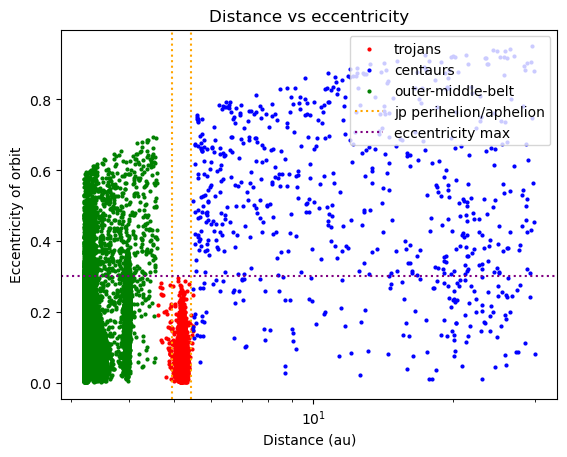

In [6]:
plt.scatter(trojans["a"], trojans["e"], c = "r", s = 4, label = "trojans")
plt.scatter(centaurs["a"], centaurs["e"], c = "b", s = 4, label = "centaurs")
plt.scatter(outermb["a"], outermb["e"], c = "g", s = 4, label = "outer-middle-belt")
plt.axvline(perihelion["jupiter"], c = "orange", linestyle = ":", label = "jp perihelion/aphelion")
plt.axvline(aphelion["jupiter"], c = "orange", linestyle = ":")
plt.axhline(emax, c = "purple", linestyle = ":", label = "eccentricity max")
plt.legend(loc = 'upper right')
plt.semilogx()
plt.title("Distance vs eccentricity")
plt.xlabel("Distance (au)")
plt.ylabel("Eccentricity of orbit")
plt.show()

### Perform & show accuracy of predictions

As we can see accuracy here is very high (99.5%). This establishes this method as a good predictor of if an asteroid is a trojan.

In [7]:
predtrojans = trojans[(trojans["a"] >= aphelion["jupiter"]) & (trojans["a"] <= perihelion["jupiter"])]
predtrojans = predtrojans[predtrojans["e"] <= emax]

In [8]:
accuracy = len(predtrojans) / len(trojans)
print(accuracy)

0.9954106280193237


### Try with other parameters

There are many many different orbital parameters. In the next few cells we will explore different groups of parameters and gauge their accuracy as predictors.

In [9]:
trojans.keys()

Index(['spkid', 'full_name', 'pdes', 'name', 'prefix', 'sats', 'H', 'G',
       'diameter', 'albedo', 'rot_per', 'GM', 'BV', 'UB', 'spec_B', 'spec_T',
       'orbit_id', 'epoch', 'epoch_mjd', 'epoch_cal', 'equinox', 'e', 'a', 'q',
       'i', 'om', 'w', 'ma', 'ad', 'n', 'tp', 'tp_cal', 'per', 'per_y', 'moid',
       'moid_ld', 'moid_jup', 't_jup', 'sigma_e', 'sigma_a', 'sigma_q',
       'sigma_i', 'sigma_om', 'sigma_w', 'sigma_ma', 'sigma_ad', 'sigma_n',
       'sigma_tp', 'sigma_per', 'class', 'producer', 'data_arc', 'first_obs',
       'last_obs', 'n_obs_used', 'condition_code', 'rms'],
      dtype='object')

## Predictions based on time dependent properties

Here we look at the argument of periapsis and the mean anomaly. Each of these variables can span from 0-360 degrees. Additionally, their value depends on where in orbit the small bodies were observed. Since this is essentially random, we get random data output. Hence with the information we have this is a useless parameter for measuring if a small body is an asteroid.

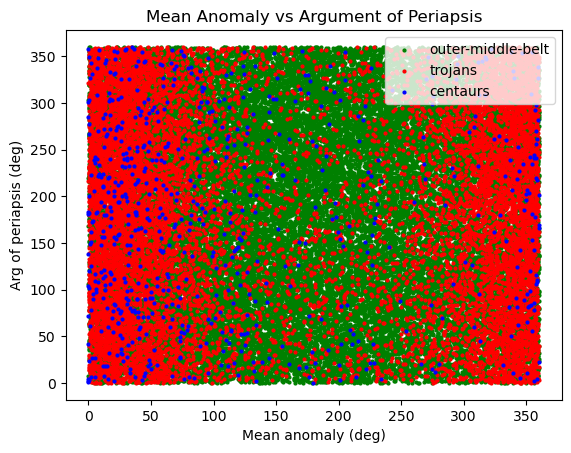

In [10]:
plt.scatter(outermb["ma"], outermb["w"], c = "g", s = 4, label = "outer-middle-belt")
plt.scatter(trojans["ma"], trojans["w"], c = "r", s = 4, label = "trojans")
plt.scatter(centaurs["ma"], centaurs["w"], c = "b", s = 4, label = "centaurs")
plt.legend(loc = 'upper right')
plt.title("Mean Anomaly vs Argument of Periapsis")
plt.xlabel("Mean anomaly (deg)")
plt.ylabel("Arg of periapsis (deg)")
plt.show()

## MOID (Minimum orbit intersection difference)

MOID is defined as the minimum distance an orbit has to another orbit.

In this section we use the MOID for earth and the MOID for jupiter to predict trojan likelyhood. In an ideal circumstance, the MOID for jupiter should be very small as the trojans orbit very close to the orbit of jupiter. And for all others the MOID for jupiter should be larger.

Additionally, this could be used to predict the other classes as CEN (centaur) small bodies should have a smaller moid with respect to earth.

Lastly, we include eccentricity in these predictions.

<IPython.core.display.Javascript object>


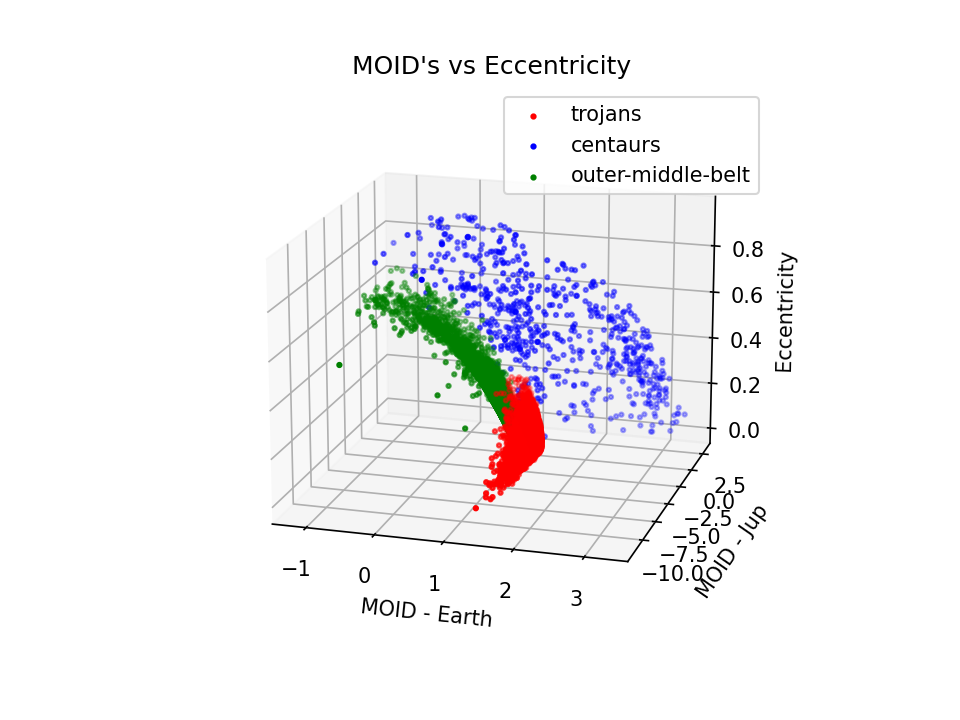

In [11]:
%matplotlib notebook

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(np.log(trojans["moid"]), np.log(trojans["moid_jup"]), trojans["e"], c = "r", s = 4, label = "trojans")
ax.scatter(np.log(centaurs["moid"]), np.log(centaurs["moid_jup"]), centaurs["e"], c = "b", s = 4, label = "centaurs")
ax.scatter(np.log(outermb["moid"]), np.log(outermb["moid_jup"]), outermb["e"], c = "g", s = 4, label = "outer-middle-belt")
ax.legend(loc = 'upper right')
ax.set_title("MOID's vs Eccentricity")
ax.set_xlabel("MOID - Earth")
ax.set_ylabel("MOID - Jup")
ax.set_zlabel("Eccentricity")
plt.show()

## Predicting via Support Vector Machines

Support vector machines essentially place a vector, plane, or hyperplane into the data, and tune it until it separates the data with the best accuracy. 

It does so by placing parallel objects known as support vectors on either side of the dividing boundary and does it's best to maximize the bounds on either side.

![SVM](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fdataaspirant.com%2Fwp-content%2Fuploads%2F2017%2F01%2FSupport-vector-machine-svm.jpg&f=1&nofb=1&ipt=7bee91086f6d436f5b99fb4ffbfa014466736fcc4b3c116ac8d41f3a766c71e4&ipo=images)

*We dont't need to worry about these warnings*

### Create a dataframe to perform SVM

We will be training this model on *minimum orbit intersection distane (MOID) for earth & jupiter*, as well as *eccentricity*, and the *perihelion distance*. 

In [14]:
# set up dataframe
trojans["id"] = [1]*len(trojans)
centaurs["id"] = [0]*len(centaurs)
outermb["id"] = [0]*len(outermb)

fulldf = trojans.append(centaurs.append(outermb))

inputs = ["moid", "moid_jup", "e", "q"]
target = ["id"]

fulldf = pd.DataFrame({"moid":fulldf["moid"], "moid_jup":fulldf["moid_jup"], "e":fulldf["e"], "id":fulldf["id"], "q":fulldf["q"]})
fulldf = fulldf.dropna()

C:\Users\Nacnu\AppData\Local\Temp\ipykernel_13364\1513533723.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fulldf = trojans.append(centaurs.append(outermb))
C:\Users\Nacnu\AppData\Local\Temp\ipykernel_13364\1513533723.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fulldf = trojans.append(centaurs.append(outermb))


Split dataframe into training and testing. `25%` of the data will be used for training.

In [15]:
train, test = train_test_split(fulldf, test_size=0.25)

Drop Nan values

In [16]:
train_inputdf = train[inputs].dropna()
train_targetdf = train[target].dropna()

test_inputdf = test[inputs].dropna()
test_targetdf = test[target].dropna()

### Create and test model

In [17]:
#create a model object
model = SVC(kernel="linear", C=5)

#train our model
model.fit(train[inputs], train[target])

#evaluate the model 
score = model.score(test[inputs], test[target])
print(f"score: {score}")

# make predictons for confusion matrix
predicted = model.predict(test[inputs])

#confusion matrix
conf_matrix = confusion_matrix(test[target], predicted)
print(f"Confusion matrix: \n {conf_matrix}")

#classification report
print(classification_report(test[target], predicted))

C:\Users\Nacnu\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score: 0.9959693047050616
Confusion matrix: 
 [[9658   19]
 [  33 3191]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9677
           1       0.99      0.99      0.99      3224

    accuracy                           1.00     12901
   macro avg       1.00      0.99      0.99     12901
weighted avg       1.00      1.00      1.00     12901



### Evaluating model accuracy

The model performed extremely well with an accuracy of 99.64%

**Confusion Matrix**

This allows us to evaluate where the model fell through.

It is formatted as such:

|       | Pred Non-Trojan | Pred Trojan |
|-------|--------|--------|
| Act Non-Trojan |  9658  |   19   |
| Act Trojan |   33   |  3191  |

So, it correctly predicted 9658 non-trojans and 3191 trojans, while accidentaly predicting 19 trojans as non-trojans, and 33 non-trojans as trojans.

Precision, recall, and f1-score are usually useful parameters to help tune a model, however due to the lack of significant figures and the accuracy of the model, these are not terribly useful as values tend to round up to 1.